# Anomaly Detection - Phát hiện bất thường

Notebook này thực hiện phát hiện anomalies sử dụng Isolation Forest và Local Outlier Factor (LOF).

## Mục tiêu:
1. Phát hiện cầu thủ có chỉ số bất thường
2. Phát hiện đội bóng có chỉ số bất thường
3. Phân tích và visualize outliers


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../src')
from anomaly_detection import analyze_player_anomalies, analyze_team_anomalies

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Đã import các modules cần thiết")


✅ Đã import các modules cần thiết


## 1. Phát hiện anomalies cho cầu thủ


PHÁT HIỆN ANOMALIES CHO CẦU THỦ

📊 Kết quả:
  - Isolation Forest outliers: 58
  - LOF outliers: 58
  - Cả 2 methods phát hiện: 4

🔍 Top Outliers (Isolation Forest):
                 Player Pos            Squad
2     Aaron Wan-Bissaka  DF         West Ham
14           Alex Iwobi  FW           Fulham
18       Alexander Isak  FW    Newcastle Utd
19  Alexis Mac Allister  MF        Liverpool
28      Andreas Pereira  MF           Fulham
29     Andrew Robertson  DF        Liverpool
34       Anthony Elanga  FW  Nott'ham Forest
36      Antoine Semenyo  FW      Bournemouth
37     Antonee Robinson  DF           Fulham
72      Bruno Fernandes  MF   Manchester Utd

🔍 Top Outliers (LOF - Highest Scores):
              Player Pos           Squad  LOF_Score
500  Shumaira Mheuka  MF         Chelsea  12.289235
227      Jakub Moder  MF        Brighton  10.898382
193     Harry Howell  FW        Brighton   6.460382
380     Matt Targett  DF   Newcastle Utd   3.861223
273      Jordan Ayew  FW  Crystal Palace

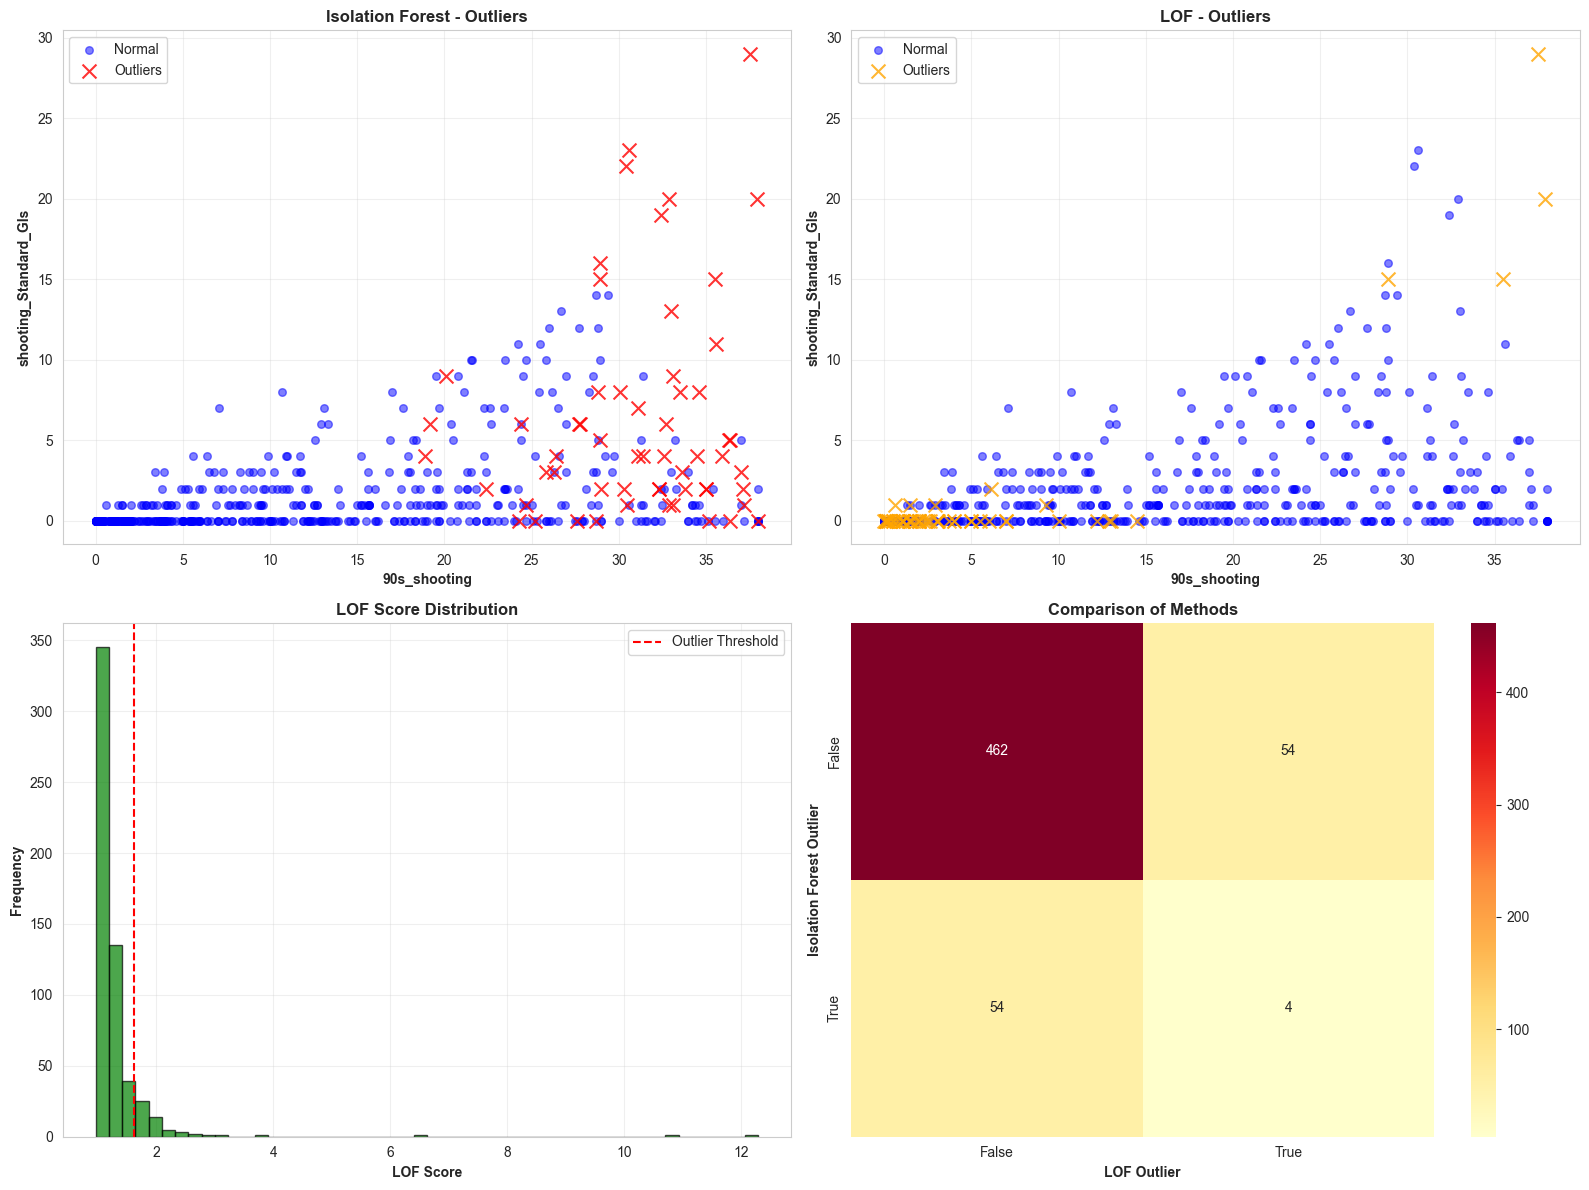


✅ Đã lưu kết quả anomalies cầu thủ


In [2]:
# Load dữ liệu
try:
    players_df = pd.read_excel('../data/players_processed.xlsx')
except:
    from data_preprocessing import load_data, feature_engineering_players, prepare_data_for_analysis
    data = load_data()
    players_df = feature_engineering_players(data['players'])
    players_df = prepare_data_for_analysis(players_df)

# Phát hiện anomalies
print("="*70)
print("PHÁT HIỆN ANOMALIES CHO CẦU THỦ")
print("="*70)

player_anomalies = analyze_player_anomalies(players_df, contamination=0.1)

if player_anomalies:
    df_anomalies = player_anomalies['df_with_anomalies']
    
    print(f"\n📊 Kết quả:")
    print(f"  - Isolation Forest outliers: {player_anomalies['isolation_forest']['n_outliers']}")
    print(f"  - LOF outliers: {player_anomalies['lof']['n_outliers']}")
    print(f"  - Cả 2 methods phát hiện: {df_anomalies['Both_Methods_Outlier'].sum()}")
    
    # Hiển thị outliers
    print("\n🔍 Top Outliers (Isolation Forest):")
    iso_outliers = df_anomalies[df_anomalies['IsolationForest_Outlier']]
    if 'Player' in iso_outliers.columns:
        print(iso_outliers[['Player', 'Pos', 'Squad']].head(10))
    
    print("\n🔍 Top Outliers (LOF - Highest Scores):")
    lof_outliers = df_anomalies[df_anomalies['LOF_Outlier']].nlargest(10, 'LOF_Score')
    if 'Player' in lof_outliers.columns:
        print(lof_outliers[['Player', 'Pos', 'Squad', 'LOF_Score']].head(10))
    
    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Tìm các cột quan trọng để visualize
    feature_cols = player_anomalies['feature_cols']
    if len(feature_cols) >= 2:
        col1, col2 = feature_cols[0], feature_cols[1]
        
        # Isolation Forest
        ax1 = axes[0, 0]
        normal = df_anomalies[~df_anomalies['IsolationForest_Outlier']]
        outliers = df_anomalies[df_anomalies['IsolationForest_Outlier']]
        ax1.scatter(normal[col1], normal[col2], alpha=0.5, s=30, label='Normal', color='blue')
        ax1.scatter(outliers[col1], outliers[col2], alpha=0.8, s=100, label='Outliers', color='red', marker='x')
        ax1.set_xlabel(col1, fontweight='bold')
        ax1.set_ylabel(col2, fontweight='bold')
        ax1.set_title('Isolation Forest - Outliers', fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # LOF
        ax2 = axes[0, 1]
        normal_lof = df_anomalies[~df_anomalies['LOF_Outlier']]
        outliers_lof = df_anomalies[df_anomalies['LOF_Outlier']]
        ax2.scatter(normal_lof[col1], normal_lof[col2], alpha=0.5, s=30, label='Normal', color='blue')
        ax2.scatter(outliers_lof[col1], outliers_lof[col2], alpha=0.8, s=100, label='Outliers', color='orange', marker='x')
        ax2.set_xlabel(col1, fontweight='bold')
        ax2.set_ylabel(col2, fontweight='bold')
        ax2.set_title('LOF - Outliers', fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # LOF Scores distribution
        ax3 = axes[1, 0]
        ax3.hist(df_anomalies['LOF_Score'], bins=50, alpha=0.7, color='green', edgecolor='black')
        ax3.axvline(df_anomalies[df_anomalies['LOF_Outlier']]['LOF_Score'].min(), 
                   color='red', linestyle='--', label='Outlier Threshold')
        ax3.set_xlabel('LOF Score', fontweight='bold')
        ax3.set_ylabel('Frequency', fontweight='bold')
        ax3.set_title('LOF Score Distribution', fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Comparison
        ax4 = axes[1, 1]
        comparison = pd.crosstab(df_anomalies['IsolationForest_Outlier'], df_anomalies['LOF_Outlier'])
        sns.heatmap(comparison, annot=True, fmt='d', cmap='YlOrRd', ax=ax4)
        ax4.set_xlabel('LOF Outlier', fontweight='bold')
        ax4.set_ylabel('Isolation Forest Outlier', fontweight='bold')
        ax4.set_title('Comparison of Methods', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../results/anomaly_detection/player_anomalies.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Lưu kết quả
    if 'Player' in df_anomalies.columns:
        df_anomalies[['Player', 'Pos', 'Squad', 'IsolationForest_Outlier', 'LOF_Outlier', 
                     'Both_Methods_Outlier', 'LOF_Score']].to_csv(
            '../results/anomaly_detection/player_anomalies.csv', index=False)
        print("\n✅ Đã lưu kết quả anomalies cầu thủ")


## 2. Phát hiện anomalies cho đội bóng


PHÁT HIỆN ANOMALIES CHO ĐỘI BÓNG

📊 Kết quả:
  - Isolation Forest outliers: 4
  - LOF outliers: 4
  - Cả 2 methods phát hiện: 0

🔍 Outliers (Isolation Forest):
             Squad
0        Liverpool
17  Leicester City
18    Ipswich Town
19     Southampton


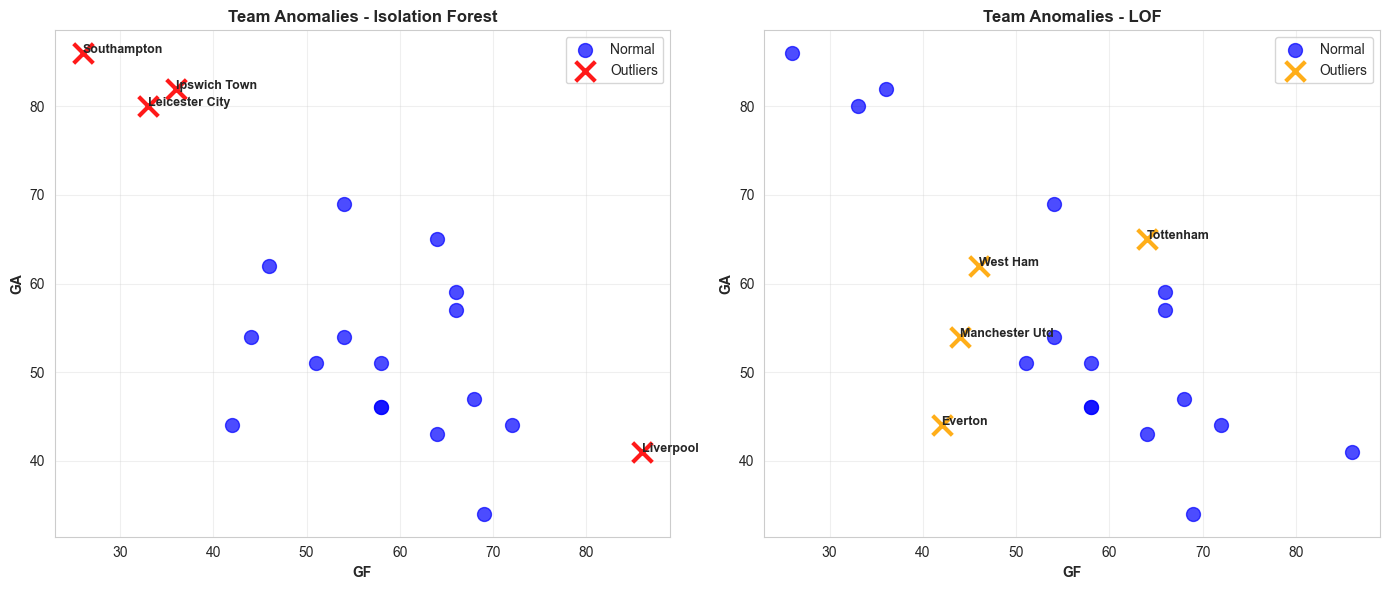


✅ Đã lưu kết quả anomalies đội bóng


In [3]:
# Load dữ liệu đội bóng
try:
    teams_df = pd.read_excel('../data/teams_processed.xlsx')
except:
    from data_preprocessing import load_data, feature_engineering_teams, prepare_data_for_analysis
    data = load_data()
    teams_merged = feature_engineering_teams(data['teams_for'], data['teams_vs'])
    if teams_merged is not None:
        teams_df = prepare_data_for_analysis(teams_merged, target_cols=['Squad'])
    else:
        teams_df = None

if teams_df is not None:
    print("="*70)
    print("PHÁT HIỆN ANOMALIES CHO ĐỘI BÓNG")
    print("="*70)
    
    team_anomalies = analyze_team_anomalies(teams_df, contamination=0.2)
    
    if team_anomalies:
        df_team_anomalies = team_anomalies['df_with_anomalies']
        
        print(f"\n📊 Kết quả:")
        print(f"  - Isolation Forest outliers: {team_anomalies['isolation_forest']['n_outliers']}")
        print(f"  - LOF outliers: {team_anomalies['lof']['n_outliers']}")
        print(f"  - Cả 2 methods phát hiện: {df_team_anomalies['Both_Methods_Outlier'].sum()}")
        
        # Hiển thị outliers
        print("\n🔍 Outliers (Isolation Forest):")
        iso_outliers = df_team_anomalies[df_team_anomalies['IsolationForest_Outlier']]
        if 'Squad' in iso_outliers.columns:
            print(iso_outliers[['Squad']])
        
        # Visualize
        feature_cols = team_anomalies['feature_cols']
        if len(feature_cols) >= 2:
            col1, col2 = feature_cols[0], feature_cols[1]
            
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            
            # Isolation Forest
            ax1 = axes[0]
            normal = df_team_anomalies[~df_team_anomalies['IsolationForest_Outlier']]
            outliers = df_team_anomalies[df_team_anomalies['IsolationForest_Outlier']]
            ax1.scatter(normal[col1], normal[col2], alpha=0.7, s=100, label='Normal', color='blue')
            ax1.scatter(outliers[col1], outliers[col2], alpha=0.9, s=200, label='Outliers', 
                       color='red', marker='x', linewidths=3)
            
            # Thêm tên đội bóng
            if 'Squad' in outliers.columns:
                for idx, row in outliers.iterrows():
                    ax1.text(row[col1], row[col2], row['Squad'], fontsize=9, fontweight='bold')
            
            ax1.set_xlabel(col1, fontweight='bold')
            ax1.set_ylabel(col2, fontweight='bold')
            ax1.set_title('Team Anomalies - Isolation Forest', fontweight='bold')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # LOF
            ax2 = axes[1]
            normal_lof = df_team_anomalies[~df_team_anomalies['LOF_Outlier']]
            outliers_lof = df_team_anomalies[df_team_anomalies['LOF_Outlier']]
            ax2.scatter(normal_lof[col1], normal_lof[col2], alpha=0.7, s=100, label='Normal', color='blue')
            ax2.scatter(outliers_lof[col1], outliers_lof[col2], alpha=0.9, s=200, label='Outliers', 
                       color='orange', marker='x', linewidths=3)
            
            if 'Squad' in outliers_lof.columns:
                for idx, row in outliers_lof.iterrows():
                    ax2.text(row[col1], row[col2], row['Squad'], fontsize=9, fontweight='bold')
            
            ax2.set_xlabel(col1, fontweight='bold')
            ax2.set_ylabel(col2, fontweight='bold')
            ax2.set_title('Team Anomalies - LOF', fontweight='bold')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig('../results/anomaly_detection/team_anomalies.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Lưu kết quả
            if 'Squad' in df_team_anomalies.columns:
                df_team_anomalies[['Squad', 'IsolationForest_Outlier', 'LOF_Outlier', 
                                  'Both_Methods_Outlier', 'LOF_Score']].to_csv(
                    '../results/anomaly_detection/team_anomalies.csv', index=False)
                print("\n✅ Đã lưu kết quả anomalies đội bóng")
else:
    print("⚠️ Không có dữ liệu đội bóng")
